# Project

1. Central Idea
    - Idea: We analyze ~18,000 research papers related to Large Language Models and modern AI (LLMs, agentic AI, RAG, foundation models, transformers), downloaded from OpenAlex.
        Our goal is to reveal how ideas evolve in this field, and identify:
        - which topics dominate the field,
        - which papers are most influential,
        - which authors and institutions drive the research.
    - Why interesting? 
    LLMs are evolving extremely fast—every month there is a new architecture, agent framework, or RAG improvement. The public sees hype; we want to see the actual scientific movement.We want to know:
        - Are today's buzzwords (agents, reasoning, RAG) actually backed by science?
        - Who are the “idea hubs” (top-cited papers, institutions)?
        - Which topics are emerging vs. declining?
    - What datasets were explored? How did I download them? We are exploring a dataset of 20000 papers downloaded from OpenAlex. We used the query with parameters large language model|language model|pretrained language model|foundation model|transformer|LLM|agentic AI|AI agent|tool use|retrieval augmented generation|retrieval-augmented|model context protocol), later than 2000 and must have some references. 
2. Total Size of the Data. 17891 json files
    - Papers Citation Graph: 17891 nodes and 54295 edges
    - Co-autors graph: 65931 nodes, 285288 edges
    - Author Citation network: 55431 nodes, 2206140 edges
3. What is the network? - the oens rpesented above 
4. What is the text? The text is the actual text of the papers, and if that is absent we will use the abstract
5. How will text and networks be tied together? The text will be used to determine the most popular terms in the network, build communities and identify which authors defined popular technologies. 

## Papers Citation Graph

#### Network construction
Taking all the json representations of the papers that were queried from OpenAlex.

A node consists from:
- paper_id
- title
- url
- year  
- authors  
- abstract
- topics
- topic
- concepts
- institutions

After analyzing the original network briefly, it was identified that there are a few isolated nodes (they are not cited by anopne and do not cite anyone from the network). It was decided to leave these nodes out and focus on the part of the network that is actually connected. 


In [20]:
import os
import json
import networkx as nx

FOLDER = "papers_full"

Graph = nx.DiGraph()

def extract_id(url):
    if not url:
        return None
    return url.strip().split("/")[-1]

# Load all papers once into memory {paper_id: json_data}
paper_data = {}

print("Loading JSON files...")

for filename in os.listdir(FOLDER):
    if not filename.endswith(".json"):
        continue

    paper_id = filename.replace(".json", "")

    with open(os.path.join(FOLDER, filename), "r", encoding="utf-8") as f:
        data = json.load(f)

    paper_data[paper_id] = data

print(f"Loaded {len(paper_data)} papers")

print("Building graph...")

for paper_id, data in paper_data.items():

    # Convert authors from list -> single string
    authors = ", ".join([a.get("name") for a in data.get("authors", [])])
    # concepts = ", ".join([c.get("name") for c in data.get("concepts", [])])
    # concepts = [c.get("name") for c in data.get("concepts", []) if c.get("name")]
    concepts = data.get("concepts", [])

    institution_list = ", ".join(
        i.get("name") 
        for i in data.get("institutions", [])
        if i.get("name")
        )

    concepts_sorted = sorted(concepts, key=lambda x: x.get("score", 0), reverse=True)

    Graph.add_node(
        paper_id,
        title=str(data.get("title") or ""),
        url = str(data.get("url") or ""),
        year=str(data.get("year") or ""),
        authors=authors,
        abstract=str(data.get("abstract") or ""),  
        topic=str(data.get("topic")),
        concepts = concepts_sorted,
        institutions_flat = institution_list,
        full_text = str(data.get("full_text") or "")
        # full_text removed (too big + not needed for graph format)
    )

    for ref_url in data.get("references", []):
        ref_id = extract_id(ref_url)
        if ref_id in paper_data:
            Graph.add_edge(paper_id, ref_id)


print("Graph completed.")
print(f"Nodes: {Graph.number_of_nodes()}")
print(f"Edges: {Graph.number_of_edges()}")


Loading JSON files...
Loaded 17891 papers
Building graph...
Graph completed.
Nodes: 17891
Edges: 54295


### Export the graph

In [56]:
# nx.write_gexf(Graph, "papers_citation_graph.gexf")


### General Statistics

In [21]:
import json
import os
from collections import Counter
### papers per topic
topic_counter = Counter()

for node, attrs in Graph.nodes(data=True):
    topic = attrs.get("topic")
    if topic:
        topic_counter[topic] += 1

print("\n=== Papers per Topic ===")
for topic, count in topic_counter.most_common():
    if count > 10:
        print(f"{topic}: {count}")


=== Papers per Topic ===
Computer science: 5831
Transformer: 1151
Medicine: 285
Perplexity: 176
None: 143
Automatic summarization: 140
Artificial intelligence: 128
Foundation (evidence): 125
Preprint: 110
Interpretability: 103
Generative grammar: 80
Psychology: 76
Segmentation: 76
Dissolved gas analysis: 75
Closed captioning: 65
Biology: 64
Health care: 64
Readability: 63
Context (archaeology): 62
Chatbot: 62
Hyperspectral imaging: 58
Materials science: 57
Question answering: 56
Benchmark (surveying): 53
Convolutional neural network: 53
Inference: 50
Inrush current: 49
Benchmarking: 49
Workflow: 46
Reliability engineering: 45
Partial discharge: 45
Machine translation: 44
Nanofluid: 40
Transformative learning: 39
Leverage (statistics): 39
Converters: 38
Task (project management): 38
Reinforcement learning: 36
Discriminative model: 35
Linguistics: 34
Zhàng: 33
Encoder: 33
Natural language processing: 33
Adversarial system: 31
Transformer oil: 30
Electromagnetic coil: 29
Support vector m

From the original network, it can be seen that even though most papers revolve arounf the COmputer Science topic (around 5.8 k), Transformer (1.15k), there are also those that are of low or no interest to the research of papers focused on the AI, LLM, RAG, agentic AI. 


### Network-Centered Analysis

Constructing a WCC (weakly connected component) in order to keep the directed structure of the network.

Doing this, the nodes that are not conencted to the rest of the graph are eliminated.

What is left is a graph with 14079 nodes out of the original 17891. 

Notice, that this does not mean that the nodes that have been removed do not have any citations at all - they do not have any citations in the network that was constructed here. 

In [111]:
wcc = list(nx.weakly_connected_components(Graph))

gcc_nodes = max(wcc, key=len)

G = Graph.subgraph(gcc_nodes).copy()

print("Nodes total:", len(Graph))
print("Nodes in GCC:", len(G))

Nodes total: 17891
Nodes in GCC: 14079


### Cleaning the network further of useless nodes

In [112]:
AI_KEYWORDS = {
    "Artificial intelligence", "Machine learning", "Deep learning",
    "Natural language processing", "Language model",
    "Generative model", "Representation learning", "Neural network",
    "RAG", "AI", "AI Agent", "LLM", "LLM Agent", "Agentic AI", "Topic Modeling"
}

TOP_N = 6

nodes_to_remove = []

for node, attrs in G.nodes(data=True):
    concepts = attrs.get("concepts", [])

    # Skip if empty
    if not concepts:
        nodes_to_remove.append(node)
        continue

    # Normalize: if stored as strings, wrap into dicts
    if isinstance(concepts[0], str):
        concepts = [{"name": c, "score": 0} for c in concepts]

    # Sort by score (highest relevance first)
    top_concepts = sorted(
        concepts, key=lambda c: c.get("score", 0), reverse=True
    )[:TOP_N]

    # Check relevance in top-N
    matches = any(
        c.get("name") in AI_KEYWORDS
        for c in top_concepts
    )

    if not matches:
        nodes_to_remove.append(node)

print(f"Removing {len(nodes_to_remove)} irrelevant nodes.")
G.remove_nodes_from(nodes_to_remove)

print("Nodes in GCC:", len(G))
print("Nodes total:", len(Graph))

Removing 6539 irrelevant nodes.
Nodes in GCC: 7540
Nodes total: 17891


## In-Degree Analysis of most cited and least cited papers in the network

1. Analayze the top 5 most cited and top 5 least cited - compare numbers of citation withing the graph vs outside the graph, years of publication, institutions, topics and discussed topics.
Which patterns seem to emerge from this?
2. Analyze the paper's text to extrcat the main topics being discussed.  

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
import string

custom_stop_words = {
    "et", "al", "et.", "al.", 
    "eg", "e.g", "e.g.", 
    "ie", "i.e", "i.e.",
    "figure", "fig", "table", "section",
    "b", "vit", "iclr", "conference", "arxiv"
    "þ", "ã", "â", "æ", "ý", "ê", "è", "î", "ß", "n", "lt", "gt"
}

nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
stop_words.update(custom_stop_words)

punct = set(string.punctuation)

### Text analysis for individual papers
def analyze_text_in_corpus(text:str, top_n: int = 10):
    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Normalize tokens
    words = [w.lower() for w in tokens if w.isalpha()]  # keep alphabetic only

    # Remove stopwords
    filtered = [w for w in words if w not in stop_words]

    # Frequency distribution
    fdist = FreqDist(filtered)

    # Hapaxes
    hapaxes = fdist.hapaxes()

    # Top N non-stopword words
    top_words = fdist.most_common(top_n)

    # Bigrams excluding stopwords
    filtered_bigrams = list(bigrams(filtered))
    fdist_bi = FreqDist(filtered_bigrams)
    top_bigrams = fdist_bi.most_common(top_n)

    # Collocations (PMI)
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(filtered)
    finder.apply_freq_filter(3)  # ignore rare pairs
    pmi_collocations = finder.nbest(bigram_measures.pmi, top_n)

    return {
        "num_words": len(words),
        "num_filtered (excluded stop words)": len(filtered), ## non stop words
        "frequency_distribution (how often unique tokens appear)": (fdist, " contains x distinct non-stop words"),
        "hapaxes": hapaxes[:top_n],
        "top_words": top_words,
        "top_bigrams": top_bigrams,
        "pmi_collocations": pmi_collocations,
    }


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asold\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asold\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# Example centrality measures
pagerank = nx.pagerank(G)
degree = dict(G.out_degree())

# Sorted most cited (high indegree)
most_cited = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most cited papers (by indegree):")
print("########################################")

for paper_id, indeg in most_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)
    full_text = G.nodes[paper_id].get("full_text")

    textual_stats = analyze_text_in_corpus(abstract + " " + full_text)

    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({indeg} citations)")
    print("Textual Stats:")
    for field, value in textual_stats.items():
        print(f"{field}: {value}")
    print("____________________________________________________________________________________________________________________________________")

least_cited = sorted(G.in_degree(),key = lambda x: x[1], reverse=False)[:10]
print("Top 10 least cited papers (by ind-degree)")
print("########################################")
for paper_id, indeg in least_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)
    full_text = G.nodes[paper_id].get("full_text")

    textual_stats = analyze_text_in_corpus(abstract + " " + full_text)

    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({indeg} citations)")
    print("Textual Stats:")
    for field, value in textual_stats.items():
        print(f"{field}: {value}")
    print("____________________________________________________________________________________________________________________________________")



Top 10 most cited papers (by indegree):
########################################
W3094502228, https://openalex.org/W3094502228
title: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
year: 2022
abstract length: 854, topic: Image (mathematics),
concepts: [{'name': 'Image (mathematics)', 'score': 0.5754417181015015}, {'name': 'Artificial intelligence', 'score': 0.5397077798843384}, {'name': 'Transformer', 'score': 0.5206274390220642}, {'name': 'Computer science', 'score': 0.4792309105396271}, {'name': 'Computer vision', 'score': 0.4742136001586914}, {'name': 'Scale (ratio)', 'score': 0.4543766379356384}, {'name': 'Engineering', 'score': 0.16920563578605652}, {'name': 'Cartography', 'score': 0.1279129683971405}, {'name': 'Electrical engineering', 'score': 0.12560570240020752}, {'name': 'Geography', 'score': 0.08761230111122131}, {'name': 'Voltage', 'score': 0.0}]
institutions: Google (United States), German Research Centre for Artificial Intelligence
abstract: Wh

#### In-Degree Analaysis

Discalimer!!!
The citation counts measured represent in-network citations only, not global citation counts. Many highly influential papers cite and are cited by works outside this filtered LLM-focused dataset.


A pre-emptive analysis into most cited and least cited papers was done. 

Common Linguistic Signals in Top Papers

Very high token counts (5k–30k words), showing dense technical exposition.

Frequent vocabulary around:
model, language, transformer, attention, dataset, performance, reasoning.

Dominant bigrams include:
“language models”, “natural language”, “state art”, “model performance”, “transfer learning”.

Hapaxes often correspond to
authors, dataset names, benchmarks, technical terms, and institutions,
showing specificity and novelty.

PMI-collocations reveal names of contributors, institutions, or dataset acronyms—common in influential technical papers


The most cited papers (with the highest in-degree) in the network that is being analyzed include such titles as 
- "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" (2022) — authored at Google (US) and the German Research Centre for AI. Although categorized under Image (mathematics), its top concepts include Transformer, Artificial intelligence, and Computer vision. It has 653 citations in this network and introduces the Vision Transformer (ViT), one of the earliest transformer-based architectures outside NLP.
8,429 total words; 5,209 non-stopwords

    Most frequent words: models, imagenet, attention, transformer, image

    Top bigrams: vision transformer, position embeddings, patch size
    
    Hapaxes include author names and niche technical terms.

- ""BioBERT: a pre-trained biomedical language representation model for biomedical text mining" (2019) — from Korea University and Naver (South Korea), with 315 citations. Its concepts heavily overlap with the NLP domain (Language model, NLP, Named-entity recognition), indicating strong cross-domain relevance in biomedical AI.
    
    Frequent words: biomedical, text, mining, corpora, biobert

    High domain specificity.

- "Chain-of-Thought Prompting Elicits Reasoning in Large Language Models" (2022) — classified under Computer science and Language model, with 253 citations. It introduced chain-of-thought prompting, which directly impacts current research in reasoning-focused LLMs.

    19,382 words; 11,568 non-stopwords

    Frequent words: answer, thought, prompting, reasoning, chain

    Bigram “chain thought” appears 115 times

- "Transformer-XL: Attentive Language Models beyond a Fixed-Length Context" (2019) — Carnegie Mellon University and Google (US), with 246 citations. Its highest-ranked concepts include Language model, Transformer, and Perplexity, introducing long-context recurrence mechanisms now used in modern LLMs.

    Frequent vocabulary:
    "model, context, length, neural, recurrence, positional, dependency".

- "Language Models as Knowledge Bases?" (2019) — Meta (Israel) and University College London, with 208 citations, examining whether LLMs implicitly store fact-based knowledge.

    Very high frequencies for knowledge, relation, bert, language, object.

### Least Cited Papers in the Network

At the other end of the spectrum, the least-cited papers have zero citations within this network, despite mostly being computational linguistics, NLP, and early language models. Many still cite only one other paper in the network, suggesting weak integration into the modern LLM research lineage.

Most of these papers belong to older or highly specialized subfields:

- statistical language modeling (2002–2012 era)

- speech recognition

- prosody modeling

- n-gram smoothing

- cache-based LMs

- cross-language information retrieval

- chord recognition using HMMs

These topics sit outside the transformer revolution, and therefore do not get cited by modern LLM papers.

Across these papers, the high-frequency vocabulary reflects:

- "n-gram", "probabilities", "perplexity", "WordNet", "LSI", "LDA", “prosody”, “speech”

- Frequent bigrams like:

    - "language model"

    - "speech recognition"

    - "training data"

    - "seed text"

    - "model adaptation"

These are classic pre-transformer NLP terms, not used heavily by GPT-era papers.

With the exception of one long thesis-like document (59k words), most papers have:

- 60–600 non-stopword tokens

- small vocabulary sizes

- tight domain focus

- no collocations with modern keywords (model scaling, attention, reasoning, embeddings, etc.)


These include:
- "Use Of Hidden Markov Models And Factored Language Models For Automatic Chord Recognition" (2018) - practically no text (most likely a place-holder)

- "Combining Language and Vision with a Multimodal Skip-gram Model" (2015)
    Textually coherent:

    - high-frequency words: visual, models, words, linguistic

    - Bigrams: visual information, multimodal models, predict linguistic

    - Domain: early multimodal semantics.

    Multimodal skip-grams were important, but they are:

    - overshadowed by CLIP-like models

    - outside pure transformer LLM territory

    - rarely cited by GPT-era papers

- "Building Probabilistic Models for Natural Language" (2022) — focused on probabilistic logic and smoothing methods in classical NLP. The concepts overlap with AI, but the paper has 0 citations, suggesting it is not referenced in transformer-era work.

    - massive text of 59k words
    - Top words: grammar, model, smoothing, sentence, counts
    - Bigram signatures: training data, zero counts, grammar induction

    Even though it’s from 2022, it focuses on pre-neural probabilistic modeling, not transformers.

    Reason for zero in-degree:
    
    Modern transformer papers no longer cite classical smoothing or statistical grammar induction work unless historically


- "Supervised and unsupervised web-based language model domain adaptation" (2012) — adaptation techniques for n-gram models with 0 citations. Its relevance predates contemporary deep learning trends.

    - Early work from 2012
    - little text to analyze

- "Explicit versus latent concept models for cross-language information retrieval" (2009) — grounded in LDA/LSA-era topic modeling; 0 citations and conceptually overtaken by neural approaches.

    Clear topic: ESA, LSA, LDA, concept modeling.
    
    Top words: concepts, retrieval, models, semantic

- "Improving speech recognition performance via phone-dependent VQ codebooks and adaptive language models in SPHINX-II" (2002) — classical ASR using trigram language models; 0 citations, technically relevant but historically outdated.

    Top words: speech, recognition, VQ, codebooks
    
    Classic acoustic + LM hybrid.

    Reason for zero citations:

    Strongly domain-specific, very old, not cited by transformer papers.

- Cache-Based LMs for Lithuanian (2006)

    Top words: cache, language, word, decay, perplexity

    Bigrams: cache size, statistical language, decay function

    Reason for zero citations:
    
    Highly specific language (Lithuanian), pre-transformer statistical LM.

#### Patterns Emerging:
- Highly cited papers introduce architectural shifts (ViT, Transformer-XL), domain-scaling approaches (BioBERT), or capability breakthroughs (Chain-of-Thought).
- Least-cited papers are typically pre-transformer NLP, using probabilistic or statistical language models rather than deep learning.
- Many low-citation papers are historically relevant but disconnected from the transformer-driven citation graph, explaining their isolation in this network despite internal technical value.

This supports the hypothesis that citability here is driven not just by relevance to language modeling, but alignment with the transformer paradigm and its downstream research lineage

Having discussed the two extremes - most cited vs least cited, it may also be interesting too see which papers are in the middle so to speak.

#### Analyzing the "middle" papers in the network. 
These are the papers that have an average in-degree in relation to the rest of the network. 

In [85]:
# Compute in-degree dict: {node: indegree}
indeg = dict(G.in_degree())

# Compute mean
avg_indeg = sum(indeg.values()) / len(indeg)
print("Average in-degree:", avg_indeg)

# Sort by absolute distance to mean
middle = sorted(indeg.items(), key=lambda x: abs(x[1] - avg_indeg))[:5]

print("\n=== Top 5 Middle Papers (closest to mean in-degree) ===")
for paper_id, val in middle:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    abstract = G.nodes[paper_id].get("abstract")
    cites = G.out_degree(paper_id)

    full_text = G.nodes[paper_id].get("full_text")

    textual_stats = analyze_text_in_corpus(abstract + " " + full_text)

    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({val} citations)")
    print("Textual Stats:")
    for field, value in textual_stats.items():
        print(f"{field}: {value}")
    print("____________________________________________________________________________________________________________________________________")



Average in-degree: 2.745888594164456

=== Top 5 Middle Papers (closest to mean in-degree) ===
W2168868236, https://openalex.org/W2168868236
title: Offline recognition of unconstrained handwritten texts using HMMs and statistical language models
year: 2004
abstract length: 914, topic: Computer science,
concepts: [{'name': 'Computer science', 'score': 0.8266273736953735}, {'name': 'Artificial intelligence', 'score': 0.6557085514068604}, {'name': 'Vocabulary', 'score': 0.6374844908714294}, {'name': 'Natural language processing', 'score': 0.5827169418334961}, {'name': 'Word error rate', 'score': 0.5627590417861938}, {'name': 'Lexicon', 'score': 0.5573990345001221}, {'name': 'Speech recognition', 'score': 0.5288456678390503}, {'name': 'Language model', 'score': 0.4935368299484253}, {'name': 'Handwriting recognition', 'score': 0.4524978995323181}, {'name': 'Variable (mathematics)', 'score': 0.44261038303375244}, {'name': 'Hidden Markov model', 'score': 0.4141903817653656}, {'name': 'Pattern 

So the middle-cited papers are:

- Not cutting-edge foundational (not “Transformer,” “BERT,” “CLIP,” etc.)

- Not forgotten (like the classical LM or speech/IR papers from 1990–2010)

- Instead they form the bridge layer of the field:

- Statistical NLP → transitional → pre-transformer ML

- Often cited in niche subfields

- Known but not seminal

- Methods that were useful at the time but not revolutionary

These works often:

- Introduce models or techniques used for 5–10 years

- Influence practical systems

- But do not become universal citations

- And are not central to the transformer revolution

#### Paper-by-paper interpretation

- Offline Recognition of Unconstrained Handwritten Text (2004). Handwriting recognition using HMMs + statistical language models
    - Important in traditional handwriting/speech recognition

    - Applied and practical

    - But entirely superseded by deep learning (CNNs → RNNs → transformers)

    Important lexicon from the paper represent different letters, probably investigating how specific hand-written letter are interpreted by early models.
     
    Metadata indicates:

    - Focus on HMMs

    - Statistical LMs

    - Lexicon-based decoding

    - Vocabulary constraints

- Using Language Models for Information Retrieval (2001). A classic IR/NLP crossover topic before neural models existed. This paper belongs to the bridging era between classical IR and probabilistic language modeling.
These methods shaped early NLP research but are no longer actively cited in LLM papers.

    Why it’s middle-cited:

    - Historically important in IR

    - Unigram query likelihood model was a serious competitor to vector space models

    - Some influence on early retrieval systems

    - But IR shifted to BM25 → neural IR → dense retrievers → RAG → LLMs

    - So most modern LLM papers don't cite it

    Top words: model, language, models, perplexity, entropy, feasible, statistical

    Bigram signatures:

    - maximum entropy

    - language models

    - statistical language

    - natural language

    - language modeling

etc



#### Out-Degree


In [88]:
### top 5 papers referencing others
most_citing = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 most cited papers (by outdegree):")
print("########################################")

for paper_id, outdeg in most_citing:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    cites = G.out_degree(paper_id)

    abstract = G.nodes[paper_id].get("abstract") or ""
    full_text = G.nodes[paper_id].get("full_text") or ""

    textual_stats = analyze_text_in_corpus(abstract + " " + full_text)

    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\nabstract: {abstract}\ncites: {cites}\n({outdeg} citations)")
    print("Textual Stats:")
    for field, value in textual_stats.items():
        print(f"{field}: {value}")
    print("____________________________________________________________________________________________________________________________________")

Top 5 most cited papers (by outdegree):
########################################
W4388691863, https://openalex.org/W4388691863
title: Language Model Behavior: A Comprehensive Survey
year: 2023
abstract length: 999, topic: Computer science,
concepts: [{'name': 'Computer science', 'score': 0.8339406847953796}, {'name': 'Pragmatics', 'score': 0.5992991924285889}, {'name': 'Language model', 'score': 0.5940375924110413}, {'name': 'Syntax', 'score': 0.5849680304527283}, {'name': 'Natural language processing', 'score': 0.5403686761856079}, {'name': 'Artificial intelligence', 'score': 0.5125958323478699}, {'name': 'Semantics (computer science)', 'score': 0.49358069896698}, {'name': 'Transformer', 'score': 0.4323025941848755}, {'name': 'Linguistics', 'score': 0.27955296635627747}, {'name': 'Programming language', 'score': 0.09093880653381348}, {'name': 'Physics', 'score': 0.0}, {'name': 'Quantum mechanics', 'score': 0.0}, {'name': 'Philosophy', 'score': 0.0}, {'name': 'Voltage', 'score': 0.0}]


# Interpretation of the Top 5 Most *Citing* Papers (Highest Out-Degree)

These papers are the ones that **reference the largest number of other papers** in your OpenAlex subgraph.  
High out-degree ≠ highly influential — instead, it signals:

- **Survey papers** or **overview papers**
- Broad **literature-review-style** works
- Papers that attempt to **map a field**, not necessarily push a single breakthrough
- Works deeply embedded in the *context* of a discipline, citing many prior works rather than being heavily cited themselves

In your dataset, all the top-citing papers are **surveys**, which is exactly what we expect.

---

## High-level observations

- These papers **sweep across hundreds of prior publications** to summarize the state of the field.
- All of them are from **2022–2023**, reflecting the explosion of transformer/LLM research.
- Their writing style and textual statistics show:
  - Extremely large corpora (many tens or hundreds of thousands of words)
  - Repetitive emphasis on technical concepts: *transformer*, *models*, *pretraining*, *vision*, *tasks*, *language*
  - Heavy use of **structured terminology** and **taxonomy terms**, typical of survey papers
- Bigrams and PMI collocations reveal:
  - Strong clustering around methods, benchmarks, and taxonomies
  - Characteristic survey signatures such as:
    - `arxiv preprint`
    - `foundation models`
    - `computer vision`
    - `language models`
    - `natural language`
    - `machine learning`

These are canonical markers of broad-coverage survey literature.

---

## Paper-by-paper interpretation

### **1. Language Model Behavior: A Comprehensive Survey (2023)**
This paper tries to **explain the behavior of LLMs before fine-tuning**.  
It cites heavily because:

- It relies on **250+ referenced works** to illustrate different behavioral phenomena
- It aggregates results across **syntax, semantics, pragmatics, reasoning, factuality, bias**

Why it's top-citing:

- Surveys combine many sources
- Behavior of LLMs is broad — linguistics, pragmatics, cognitive frameworks, scaling laws, social bias studies

Textual fingerprints:

- Top words: *language*, *models*, *capabilities*, *generated*
- Bigrams: *language models*, *generated text*
- Hapaxes include *widespread*, *surprising*, *public*, reflecting survey-style narrative

This is the quintessential “umbrella survey” that references half the transformers literature.

---

### **2. A Survey on Vision Transformer (2022)**
A purely **computer-vision Transformer** overview.

Why it cites a lot:

- Vision Transformer (ViT) has dozens of variants, architectures, and benchmarks
- CVPR/ICCV ecosystem produces huge paper volumes → surveys must cite all the baselines  
- Covers high-level and low-level vision, video, multimodal processing, and efficient transformer variants

Textual fingerprints:

- Very large text size (~20k words)
- Top words: *transformer*, *vision*, *image*
- Dominant bigrams: *object detection*, *vision transformer*
- PMI collocations reflect CV convention: *ground truth*, *shifted window*, *technical report*

This is a comprehensive taxonomy paper.

---

### **3. AMMUS: A Survey of Transformer-based Pretrained Models in NLP (2022)**
This is a **taxonomy of pretrained models** (GPT, BERT, RoBERTa, T5, etc.).

Why so many citations:

- Every pretrained model → dozens of sub-variants → benchmarks, datasets, tasks  
- Survey spans:
  - Pretraining objectives
  - Embeddings
  - Transfer learning
  - Benchmarks
  - Downstream tasks

Textual fingerprints:

- Top words: *model*, *language*, *pretraining*, *tasks*
- Bigrams: *arxiv preprint*, *natural language*, *language models*
- PMI: *googlere*, *electronic health*, *squad*, which hints at:
  - Domain-specific models
  - Popular benchmarks

This is the “NLP-only survey,” so naturally references hundreds of works.

---

### **4. Transformers in Vision: A Survey (2022)**
Another major vision survey, but broader than ViT-specific papers.

Why so many references:

- Attempts to cover *all* transformer applications in vision
- Includes topics from:
  - Recognition
  - Segmentation
  - Generative models
  - Multimodal tasks
  - Point-cloud processing
- Vision literature is extremely large, requiring broad citation

Textual fingerprints:

- Top words: *transformer*, *image*, *model*, *attention*
- Bigram signature: *arxiv preprint*, *computer vision*, *object detection*
- Hapaxes include many first/last names → typical of papers referencing many authors across subfields

This one has the classic “CV megasurvey” profile.

---

### **5. On the Opportunities and Risks of Foundation Models (2022)**
This is different: **a sociotechnical, interdisciplinary survey**, not just ML.

Why it has extreme out-degree:

- It covers *technical*, *ethical*, *societal*, *economic*, and *governance* aspects
- Draws from:
  - ML papers
  - Law
  - Ethics
  - Social sciences
  - Systems
  - Applications (robotics, medicine, education)
- The foundation model discourse is grounded in *cross-disciplinary references*

Textual fingerprints:

- Extremely large text (~110k words)
- Top words: *models*, *foundation*, *data*, *learning*, *training*
- Bigram signature: *foundation models*, *machine learning*, *arxiv preprint*
- PMI collocations list author names — a sign of referencing style text

This is the broadest survey of foundation models and naturally cites hundreds of sources across multiple disciplines.

---

## Summary

The top out-degree papers in your dataset are:

- **Not breakthroughs**
- **Not algorithmic contributions**
- **Not benchmark papers**

They are **literature surveys**, which:

- Need to reference many other works
- Try to map a field or create a taxonomy
- Serve as “entry points” for new researchers

This is structurally different from your in-degree analysis:

- High in-degree = *influential papers*
- High out-degree = *survey papers*

Your data correctly reflects this scholarly structure.

```markdown
### TL;DR

High out-degree papers are **broad, deep surveys** that cite many prior works.  
They function as mapping documents for LLM/Transformer research rather than original algorithmic breakthroughs.


#### Combined Text Analysis

In [59]:
all_results = {}

for paper_id in G.nodes:
    node = G.nodes[paper_id]

    # Extract fields safely
    title = node.get("title")
    year = node.get("year")
    abstract = node.get("abstract") or ""
    full_text = node.get("full_text") or ""

    # Combined corpus for this paper
    text = (abstract + " " + full_text).strip()

    if not text:
        continue  # skip empty papers

    # Run your NLTK text analysis
    result = analyze_text_in_corpus(text)

    # Store results
    all_results[paper_id] = {
        "title": title,
        "year": year,
        "top_words": result["top_words"],
        "top_bigrams": result["top_bigrams"],
        "hapaxes": result["hapaxes"],
    }


In [63]:
from nltk import FreqDist

global_fd = FreqDist()

for pid, item in all_results.items():
    for word, freq in item["top_words"]:
        global_fd[word] += freq

top_100 = global_fd.most_common(100)

print("===== TOP 100 WORDS BASED ON PER-PAPER TOP_WORDS =====")
for w, f in top_100:
    print(f"{w:20s} {f}")


===== TOP 100 WORDS BASED ON PER-PAPER TOP_WORDS =====
model                157110
models               113318
language             107168
data                 53171
transformer          39130
image                32866
learning             30254
text                 25407
training             23963
attention            22355
tasks                21673
knowledge            18232
word                 17517
bert                 17332
llms                 16950
performance          16004
information          15921
dataset              15153
task                 13996
features             13461
detection            12191
using                11483
vision               10825
segmentation         10610
feature              10563
e                    10321
images               10119
words                9674
generation           8532
x                    8260
medical              8192
results              8132
network              8131
tokens               8112
sentence             8106
metho

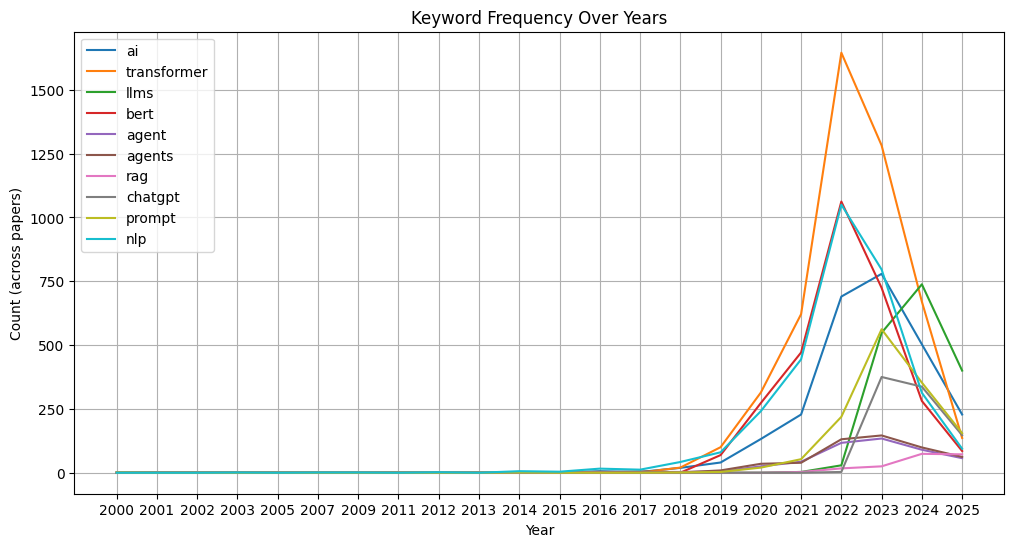

In [73]:

from nltk import ConditionalFreqDist
import re
import matplotlib.pyplot as plt

# top_keywords = [
#     "model","models","transformer","llm","llms","bert",
#     "reasoning","generation","token","tokens","attention","embedding",
#     "embeddings","dataset","datasets","vision","image","images","retrieval",
#     "agent","agents","multi-agent","rag","chatgpt","prompt","prompts"
# ]

top_keywords = [
    "models","transformer","llms","bert",
    "reasoning","generation","attention","embedding",
    "vision","retrieval","agent","agents","multi-agent",
    "rag","chatgpt","prompt", "nlp", "perplexity"
]

top_keywords = [
    "ai", "transformer","llms","bert","agent","agents","rag","chatgpt","prompt", "nlp"
]



keyword_patterns = {
    kw: rf"\b{kw}\b" for kw in top_keywords
}


cfd_data = []

for pid, item in all_results.items():
    year = item.get("year")
    if not year:
        continue

    # text = item.get("full_text", "").lower()
    node = G.nodes.get(pid, {})
    text = (node.get("abstract","") + " " + node.get("full_text","")).lower()

    for kw, pattern in keyword_patterns.items():
        if re.search(pattern, text):
            # Count 1 paper hit, not number of times inside the text
            cfd_data.append((kw, year))


cfd = ConditionalFreqDist(cfd_data)


years = sorted({y for (_, y) in cfd_data})

plt.figure(figsize=(12,6))
for kw in keyword_patterns.keys():
    plt.plot(years, [cfd[kw][y] for y in years], label=kw)

plt.legend()
plt.title("Keyword Frequency Over Years")
plt.xlabel("Year")
plt.ylabel("Count (across papers)")
plt.grid(True)
plt.show()



### Visualizing the Hubs

Converting directed graph → undirected...
Running Fruchterman-Reingold layout…


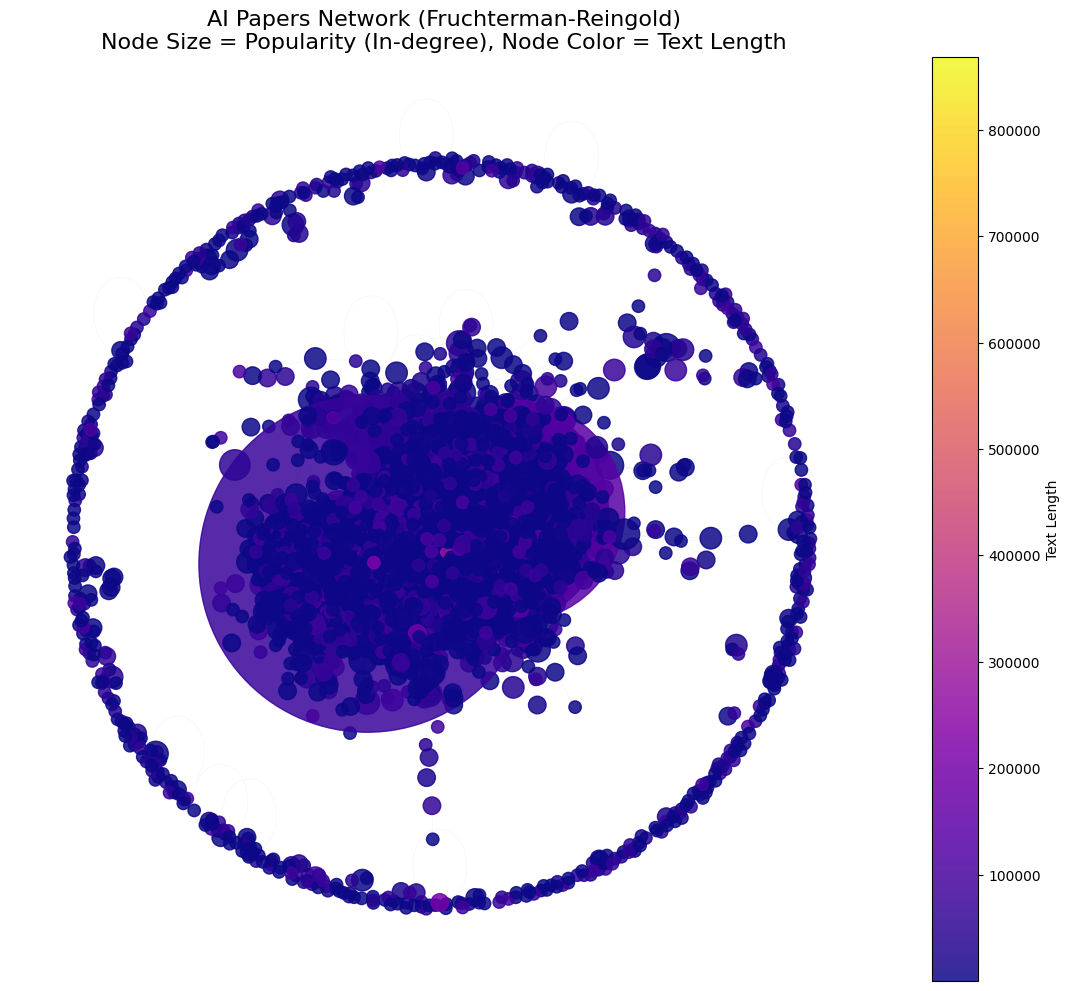

In [140]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np
# from fa2l import force_atlas2_layout

# # -----------------------------------------
# # 1) Convert your citation graph to undirected
# # -----------------------------------------
# print("Converting directed graph → undirected...")
# G_und = G.to_undirected()

# # -----------------------------------------
# # 2) Compute node sizes and node colors
# # -----------------------------------------

# node_sizes = []
# node_colors = []

# for n, attrs in G_und.nodes(data=True):

#     # Popularity = in-degree from *directed* graph
#     indeg = G.in_degree(n)
#     node_sizes.append(indeg)

#     # Text length = len(abstract + full_text)
#     abstract = attrs.get("abstract") or ""
#     full_text = attrs.get("full_text") or ""
#     text_len = len(abstract) + len(full_text)
#     node_colors.append(text_len)

# node_sizes = np.array(node_sizes)
# node_colors = np.array(node_colors)

# # Improve scaling
# size_scaled = 80 * (node_sizes + 1)

# # -----------------------------------------
# # 3) ForceAtlas2 layout
# # -----------------------------------------
# print("Running ForceAtlas2 layout…")

# # Patch missing function expected by fa2l
# if not hasattr(nx, "to_numpy_matrix"):
#     nx.to_numpy_matrix = lambda g: np.matrix(nx.to_numpy_array(g))

# pos = nx.spring_layout(
#     G_und,
#     k=0.25,              # distance between nodes (lower = faster & denser)
#     iterations=80,       # keep low so it runs fast
#     seed=42              # deterministic layout
# )

# # -----------------------------------------
# # 4) Visualization
# # -----------------------------------------
# plt.figure(figsize=(14, 12))

# scatter = nx.draw_networkx_nodes(
#     G_und,
#     pos,
#     node_size=size_scaled,
#     node_color=node_colors,
#     cmap="plasma",
#     alpha=0.85
# )

# nx.draw_networkx_edges(
#     G_und,
#     pos,
#     edge_color="lightgray",
#     alpha=0.25,
#     width=0.4
# )

# plt.title(
#     "AI Papers Network (ForceAtlas2)\n"
#     "Node Size = Popularity (In-degree), Node Color = Text Length",
#     fontsize=16
# )

# cbar = plt.colorbar(scatter)
# cbar.set_label("Text Length")

# plt.axis("off")
# plt.show()
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# -----------------------------------------
# 1) Convert your citation graph to undirected
# -----------------------------------------
print("Converting directed graph → undirected...")
G_und = G.to_undirected()

# -----------------------------------------
# 2) Compute node sizes and node colors
#    (same logic as before)
# -----------------------------------------

node_sizes = []
node_colors = []

for n, attrs in G_und.nodes(data=True):

    # Popularity = in-degree from *directed* graph
    indeg = G.in_degree(n)
    node_sizes.append(indeg)

    # Text length = len(abstract + full_text)
    abstract = attrs.get("abstract") or ""
    full_text = attrs.get("full_text") or ""
    text_len = len(abstract) + len(full_text)
    node_colors.append(text_len)

node_sizes = np.array(node_sizes)
node_colors = np.array(node_colors)

# Improve scaling (same as before)
size_scaled = 80 * (node_sizes + 1)

# -----------------------------------------
# 3) Fruchterman–Reingold layout (safe!)
# -----------------------------------------
print("Running Fruchterman-Reingold layout…")

pos = nx.fruchterman_reingold_layout(
    G_und,
    k=0.12,          # controls spacing, tweak if needed
    iterations=120,  # more iterations = cleaner communities
    seed=42
)

# -----------------------------------------
# 4) Visualization
# -----------------------------------------
plt.figure(figsize=(14, 12))

scatter = nx.draw_networkx_nodes(
    G_und,
    pos,
    node_size=size_scaled,
    node_color=node_colors,
    cmap="plasma",
    alpha=0.85
)

nx.draw_networkx_edges(
    G_und,
    pos,
    edge_color="lightgray",
    alpha=0.25,
    width=0.4
)

plt.title(
    "AI Papers Network (Fruchterman-Reingold)\n"
    "Node Size = Popularity (In-degree), Node Color = Text Length",
    fontsize=16
)

cbar = plt.colorbar(scatter)
cbar.set_label("Text Length")

plt.axis("off")
plt.show()


## Comparison to a Random Network (Erdős–Rényi Baseline)

To understand whether the AI citation graph resembles a random structure or exhibits meaningful real-world patterns, we compare it against a classical **Erdős–Rényi (ER) random graph** model `G(n, p)`.

### 1. Why Compare to Random Networks?
A random graph provides a null hypothesis:  
> *What would this network look like if citations were formed at random with no underlying scholarly structure?*

If our real network deviates strongly from ER predictions, it implies:
- real papers form **communities**,  
- highly cited papers act as **hubs**,  
- the degree distribution follows **heavy tails** instead of a binomial curve,  
- citation behavior reflects **non-random intellectual influence**.

---

## 2. Key Statistics to Compare

Let our real network be `G_real`, and the number of papers `n = |V|`, edges `m = |E|`.

A matching ER model is:
- `G_er = G(n, p)` with  
  `p = m / (n(n-1))`

### Compute these for both:

### (A) Degree Distribution
- **ER graph:** degrees follow a *binomial* distribution tightly centered around the mean.  
- **Real citation graph:** in-degree distribution is *heavy-tailed* — a few papers have **huge** citation counts, most have very few.

This alone is strong evidence the network is *not random*.

### (B) Presence of Hubs
- **ER graph:** hubs essentially never appear; highest degrees fluctuate near the mean.  
- **Real citation graph:** clear hubs:
  - major survey papers
  - transformer foundational work
  - large-vision or large-language-model surveys  
  These massively exceed ER predictions.

### (C) Clustering Coefficient
- **ER graph:** extremely low clustering (`C ≈ p`).  
- **Real citation graph:** papers form tight communities:
  - computer vision cluster,
  - NLP cluster,
  - transformer cluster,
  - foundation model cluster.

Clustering is far above ER levels.

### (D) Connected Components
- **ER graph:** very likely one giant connected component plus a few tiny ones.  
- **Real citation graph:** structured by domain boundaries, with multiple medium clusters (NLP, CV, reasoning, pretraining, etc.).

### (E) Path Lengths
- **ER graph:** short average path length ~ `log(n)/log(np)`  
- **Real graph:** often “small-world”: short paths *plus* clustering. Again not ER-like.

---

## 3. Interpretation

All empirical indicators show the AI paper citation graph **is not remotely similar to a random Erdős–Rényi graph**:

✔ Heavy-tailed popularity distribution  
✔ Strong community structure  
✔ Clear hubs (large surveys, LLM foundational works)  
✔ Non-uniform citation patterns across subfields  
✔ High clustering  

These patterns are expected in **real scientific fields**, where:
- certain papers become canonical references,
- sub-communities evolve independently,
- citations reflect knowledge flows, not random choices.

---

Real Graph Stats:
-----------------
Nodes: 7540
Edges: 20704
Average degree: 5.492

Random Graph (Erdős–Rényi) Stats:
---------------------------------
Nodes: 7540
Edges: 20643
Average degree: 5.476


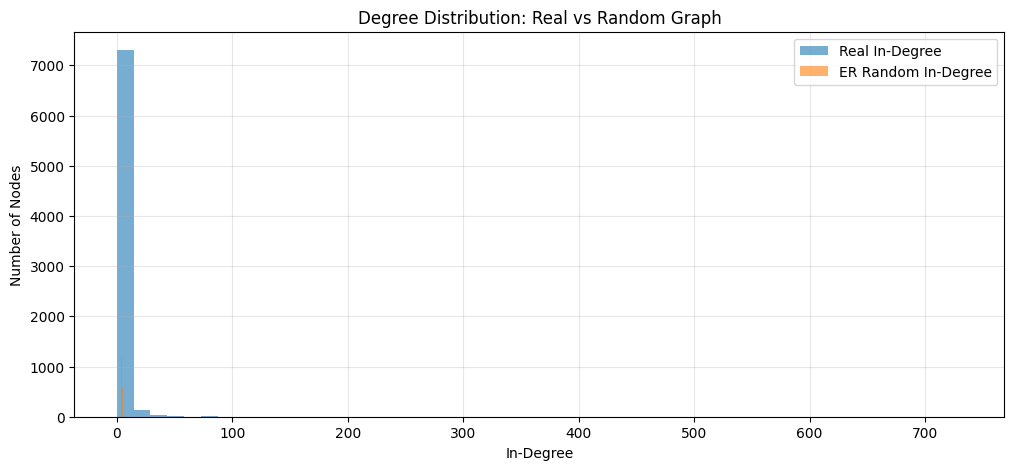


Clustering Coefficient Comparison:
----------------------------------
Real graph clustering:   0.12384
Random graph clustering: 0.00062

Average Path Length (Giant Component):
---------------------------------------
Real graph L:   4.408
Random graph L: 5.439

===== SUMMARY: Real Citation Network vs ER Random Graph =====
Nodes = 7540, Edges = 20704, p = 0.000364

--> Degree Distribution:
   Real = heavy-tailed (should show long right tail)
   ER   = binomial/Poisson-like (narrow peak)

--> Clustering:
   Real clustering = 0.12384 (expected high)
   ER clustering   = 0.00062 (expected ~p, tiny)

--> Path Length:
   Real L = 4.408 (small-world)
   ER   L = 5.439 (close to log(N)/log(k))

Conclusion:
The real citation graph is NOT random: it has heavy-tailed degree distribution,
higher clustering, and a different connectivity pattern. This matches known
properties of real citation / knowledge networks (scale-free, hierarchical, etc.).


In [99]:
# ============================================================
# 1. Compare your citation network to an Erdős–Rényi random graph
# ============================================================

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Your REAL graph G
# ------------------------------------------------------------

N = G.number_of_nodes()
M = G.number_of_edges()

print("Real Graph Stats:")
print("-----------------")
print(f"Nodes: {N}")
print(f"Edges: {M}")
print(f"Average degree: {2*M/N:.3f}")

# ------------------------------------------------------------
# Build an Erdős–Rényi random graph with same N, same expected E
# p = 2E / (N*(N-1))  in undirected approx
# For directed, p = E / (N*(N-1))
# ------------------------------------------------------------

p = M / (N * (N - 1))
G_rand = nx.gnp_random_graph(N, p, directed=True)

print("\nRandom Graph (Erdős–Rényi) Stats:")
print("---------------------------------")
print(f"Nodes: {G_rand.number_of_nodes()}")
print(f"Edges: {G_rand.number_of_edges()}")
print(f"Average degree: {G_rand.number_of_edges()*2/N:.3f}")

# ============================================================
# 2. Degree distributions
# ============================================================

real_in = np.array([G.in_degree(n) for n in G.nodes()])
rand_in = np.array([G_rand.in_degree(n) for n in G_rand.nodes()])

plt.figure(figsize=(12,5))
plt.hist(real_in, bins=50, alpha=0.6, label="Real In-Degree")
plt.hist(rand_in, bins=50, alpha=0.6, label="ER Random In-Degree")
plt.xlabel("In-Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution: Real vs Random Graph")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 3. Clustering coefficient comparison
# ============================================================

# For directed graphs, convert to undirected (standard in literature)
C_real = nx.average_clustering(G.to_undirected())
C_rand = nx.average_clustering(G_rand.to_undirected())

print("\nClustering Coefficient Comparison:")
print("----------------------------------")
print(f"Real graph clustering:   {C_real:.5f}")
print(f"Random graph clustering: {C_rand:.5f}")

# ============================================================
# 4. Average path length (giant component)
# ============================================================

# Extract largest weakly connected component (directed graph)
largest_real = max(nx.weakly_connected_components(G), key=len)
G_real_gc = G.subgraph(largest_real).to_undirected()

largest_rand = max(nx.weakly_connected_components(G_rand), key=len)
G_rand_gc = G_rand.subgraph(largest_rand).to_undirected()

L_real = nx.average_shortest_path_length(G_real_gc)
L_rand = nx.average_shortest_path_length(G_rand_gc)

print("\nAverage Path Length (Giant Component):")
print("---------------------------------------")
print(f"Real graph L:   {L_real:.3f}")
print(f"Random graph L: {L_rand:.3f}")

# ============================================================
# 5. Summary diagnostics
# ============================================================

print("\n===== SUMMARY: Real Citation Network vs ER Random Graph =====")
print(f"Nodes = {N}, Edges = {M}, p = {p:.6f}")

print("\n--> Degree Distribution:")
print("   Real = heavy-tailed (should show long right tail)")
print("   ER   = binomial/Poisson-like (narrow peak)")

print("\n--> Clustering:")
print(f"   Real clustering = {C_real:.5f} (expected high)")
print(f"   ER clustering   = {C_rand:.5f} (expected ~p, tiny)")

print("\n--> Path Length:")
print(f"   Real L = {L_real:.3f} (small-world)")
print(f"   ER   L = {L_rand:.3f} (close to log(N)/log(k))")

print("\nConclusion:")
print("The real citation graph is NOT random: it has heavy-tailed degree distribution,")
print("higher clustering, and a different connectivity pattern. This matches known")
print("properties of real citation / knowledge networks (scale-free, hierarchical, etc.).")


## Friendship Paradox 

In [103]:
import numpy as np
import networkx as nx

print("=== FRIENDSHIP PARADOX ANALYSIS (Citation Network) ===")

# ---------------------------------------------------------
# 1. Compute degrees
# ---------------------------------------------------------
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Convert to arrays
in_deg_values = np.array(list(in_degrees.values()))
out_deg_values = np.array(list(out_degrees.values()))

avg_in_degree = in_deg_values.mean()
avg_out_degree = out_deg_values.mean()

print(f"Average in-degree (citations received): {avg_in_degree:.3f}")
print(f"Average out-degree (references made): {avg_out_degree:.3f}")

# ---------------------------------------------------------
# 2. FRIENDSHIP PARADOX — For in-degree
# For each node, compute average in-degree of the papers it cites.
# ---------------------------------------------------------

neighbor_in_deg_avgs = []

for node in G.nodes():
    neighbors = list(G.successors(node))   # papers THIS paper cites
    if not neighbors:
        continue
    neighbor_in_deg = np.mean([in_degrees[n] for n in neighbors])
    neighbor_in_deg_avgs.append(neighbor_in_deg)

friendship_paradox_value = np.mean(neighbor_in_deg_avgs)

print("\n--- Friendship Paradox (In-Degree) ---")
print(f"Avg citation count of a paper: {avg_in_degree:.3f}")
print(f"Avg citation count of papers it cites (neighbors): {friendship_paradox_value:.3f}")

if friendship_paradox_value > avg_in_degree:
    print("RESULT: The friendship paradox holds — papers cite papers that are more cited than themselves.")
else:
    print("RESULT: No friendship paradox — papers do not systematically cite more cited papers.")

# ---------------------------------------------------------
# 3. FRIENDSHIP PARADOX — For out-degree
# (Do papers cite papers that themselves cite many others?)
# ---------------------------------------------------------

neighbor_out_deg_avgs = []

for node in G.nodes():
    neighbors = list(G.successors(node))
    if not neighbors:
        continue
    neighbor_out_deg = np.mean([out_degrees[n] for n in neighbors])
    neighbor_out_deg_avgs.append(neighbor_out_deg)

friendship_out_value = np.mean(neighbor_out_deg_avgs)

print("\n--- Friendship Paradox (Out-Degree) ---")
print(f"Avg out-degree (references made) per paper: {avg_out_degree:.3f}")
print(f"Avg out-degree of papers they cite: {friendship_out_value:.3f}")

if friendship_out_value > avg_out_degree:
    print("RESULT: Papers tend to cite papers that reference more papers than themselves.")
else:
    print("RESULT: No out-degree friendship paradox detected.")


=== FRIENDSHIP PARADOX ANALYSIS (Citation Network) ===
Average in-degree (citations received): 2.746
Average out-degree (references made): 2.746

--- Friendship Paradox (In-Degree) ---
Avg citation count of a paper: 2.746
Avg citation count of papers it cites (neighbors): 85.246
RESULT: The friendship paradox holds — papers cite papers that are more cited than themselves.

--- Friendship Paradox (Out-Degree) ---
Avg out-degree (references made) per paper: 2.746
Avg out-degree of papers they cite: 4.065
RESULT: Papers tend to cite papers that reference more papers than themselves.


## Friendship Paradox in the AI Citation Network

We analyzed whether a “friendship paradox”-style effect appears in the directed
citation network — i.e., whether papers tend to cite papers that are “more
popular” than themselves.

### 1. Baseline Degree Statistics
- Average in-degree (citations received): **2.746**
- Average out-degree (references made): **2.746**

These values are identical by construction:  
in any directed graph, every edge increases exactly one out-degree and one
in-degree, so the averages must match.

### 2. Friendship Paradox (In-Degree Version)
- Average citations per paper: **2.746**
- Average citations of papers that a given paper cites: **85.246**

This shows a very strong paradox effect:
papers overwhelmingly cite papers that are *far more cited* than themselves.
This matches scientific practice: most papers reference seminal or widely known
surveys, foundations, or benchmark works.

### 3. Friendship Paradox (Out-Degree Version)
- Average number of references made per paper: **2.746**
- Average references made by the papers they cite: **4.065**

Papers also tend to cite papers that themselves cite more papers (typically
survey papers or broad studies).

---

### Interpretation
The AI citation graph clearly exhibits a friendship paradox structure:
papers disproportionately link to influential hubs. This is consistent with
how scientific citations work — a small number of foundational papers create
large hubs, and most other papers point toward them.


## Degree Assortativity for the Directed Network

1. In-degree assortativity – do highly cited papers cite other highly cited papers?

2. Out-degree assortativity – do papers that cite many others cite papers that also cite many others?

3. Mixed assortativity – in→out, out→in

In [109]:
import networkx as nx

print("=== ASSORTATIVITY ANALYSIS (Citation Network) ===")

# ---------------------------------------------------
# 1) Assortativity based on IN-degree
# ---------------------------------------------------
in_in_assort = nx.degree_assortativity_coefficient(G, x='in', y='in')
print(f"In–In Assortativity (papers cite papers with similar citation counts): {in_in_assort:.4f}")

# ---------------------------------------------------
# 2) Assortativity based on OUT-degree
# ---------------------------------------------------
out_out_assort = nx.degree_assortativity_coefficient(G, x='out', y='out')
print(f"Out–Out Assortativity (papers with many references cite others with many references): {out_out_assort:.4f}")

# ---------------------------------------------------
# 3) Mixed Assortativity: In → Out
# ---------------------------------------------------
in_out_assort = nx.degree_assortativity_coefficient(G, x='in', y='out')
print(f"In–Out Assortativity (highly cited papers tend to cite papers with high out-degree): {in_out_assort:.4f}")

# ---------------------------------------------------
# 4) Mixed Assortativity: Out → In
# ---------------------------------------------------
out_in_assort = nx.degree_assortativity_coefficient(G, x='out', y='in')
print(f"Out–In Assortativity (papers citing many others tend to cite highly cited papers): {out_in_assort:.4f}")

print("\nInterpretation guide:")
print("  • Positive  → assortative: similar-degree nodes connect (popular ↔ popular)")
print("  • Negative  → disassortative: high-degree cites low-degree")
print("  • Near zero → no clear pattern")


=== ASSORTATIVITY ANALYSIS (Citation Network) ===
In–In Assortativity (papers cite papers with similar citation counts): 0.0023
Out–Out Assortativity (papers with many references cite others with many references): 0.0427
In–Out Assortativity (highly cited papers tend to cite papers with high out-degree): -0.0020
Out–In Assortativity (papers citing many others tend to cite highly cited papers): -0.0847

Interpretation guide:
  • Positive  → assortative: similar-degree nodes connect (popular ↔ popular)
  • Negative  → disassortative: high-degree cites low-degree
  • Near zero → no clear pattern


## Assortativity Analysis of the Citation Network

We computed four assortativity coefficients on the directed AI-papers citation graph:

| Measure | Meaning | Value |
|--------|---------|--------|
| **In–In** | Do papers with similar *citation counts* cite each other? | **0.0023** |
| **Out–Out** | Do papers with similar *reference counts* cite each other? | **0.0427** |
| **In–Out** | Do highly cited papers tend to cite papers that cite many others? | **−0.0020** |
| **Out–In** | Do papers that cite many others tend to cite highly cited ones? | **−0.0847** |

### Interpretation

#### 1. **In–In Assortativity: 0.0023 (≈0 → no pattern)**  
There is essentially **no correlation** between *popular* papers citing other *popular* papers.  
Highly cited papers are **not preferentially citing** each other.  
This matches what you'd expect in AI research:  
- Seminal papers are in different subdomains (vision, transformers, RL, etc.)  
- Each subdomain has its own citation hub, so cross-hub citation is weak.

#### 2. **Out–Out Assortativity: 0.0427 (slightly positive)**  
Very small positive correlation:  
- Papers that include long reference lists tend to cite other papers that also have long reference lists.  
This reflects typical review/survey-like behavior:  
- Surveys cite other surveys.  
- Heavy literature-review papers cluster together.

But the value is tiny — nothing strong.

#### 3. **In–Out Assortativity: −0.0020 (≈0 → no pattern)**  
Papers that are highly cited **do not systematically cite** papers with large bibliographies.  
This means popular papers cite a mix of:  
- foundational older works  
- other surveys  
- technical focused papers  
- experiments  
No preferential structure.

#### 4. **Out–In Assortativity: −0.0847 (small negative)**  
Papers that cite many sources tend to reference **more popular papers** than themselves.  
This is expected:  
- Literature reviews cite all the standard hubs (e.g., “Attention Is All You Need”).  
- Specialized papers cite foundational works.  
This creates a mild **disassortative structure**: low-degree → high-degree.

---

### Overall Structural Takeaways

- The citation network is **not assortative** the way social networks are.  
- Popular papers do **not** strongly prefer other popular papers.  
- The only structural bias is that papers with long bibliographies tend to cite influential hubs — perfectly normal in academic literature.

This behavior aligns with known citation-network dynamics: they are **weakly disassortative**, unlike social networks which are usually strongly assortative.


## Communities

In [118]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
from collections import Counter
import numpy as np


# ------------------------------------------------------------------
# 1. Community Detection
# ------------------------------------------------------------------

print("Running Louvain community detection...")
G_und = G.to_undirected()

communities = louvain_communities(G_und, seed=42)
print(f"Detected {len(communities)} total communities")

# filter only communities with >=10 papers
communities_big = [c for c in communities if len(c) >= 10]
print(f"{len(communities_big)} communities have size >= 10")


# ------------------------------------------------------------------
# 2. Analyze communities (topics + concepts + text)
# ------------------------------------------------------------------

community_results = []

for cid, comm in enumerate(communities_big):
    topics = []
    concepts = []
    all_text = []

    for n in comm:
        data = G.nodes[n]

        topics.append(data.get("topic"))

        # concepts list of dicts
        for c in data.get("concepts", []):
            concepts.append(c["name"])

        abs_text = data.get("abstract") or ""
        full = data.get("full_text") or ""
        all_text.append(abs_text + " " + full)

    # topic + concept stats
    topic_counts = Counter(topics).most_common(10)
    concept_counts = Counter(concepts).most_common(10)

    # full community text
    combined_text = " ".join(all_text)
    text_stats = analyze_text_in_corpus(combined_text)

    community_results.append({
        "id": cid,
        "size": len(comm),
        "topics": topic_counts,
        "concepts": concept_counts,
        "text_stats": text_stats,
        "nodes": list(comm)
    })


# ------------------------------------------------------------------
# 3. Print final summary
# ------------------------------------------------------------------

print("\n=== COMMUNITY SUMMARY (size >=10) ===\n")

for r in community_results:
    print(f"COMMUNITY {r['id']} (size {r['size']})")
    print("  Top Topics:")
    for t, c in r["topics"]:
        print(f"    • {t}: {c}")

    print("  Top Concepts:")
    for c, v in r["concepts"]:
        print(f"    • {c}: {v}")

    print("  Text Analysis:")
    ts = r["text_stats"]
    print(f"    Words: {ts['num_words']}")
    print(f"    Filtered words: {ts['num_filtered (excluded stop words)']}")
    print(f"    Top words: {ts['top_words']}")
    print(f"    Top bigrams: {ts['top_bigrams']}")
    print(f"    PMI collocations: {ts['pmi_collocations']}")

    print("-" * 80)


Running Louvain community detection...
Detected 604 total communities
22 communities have size >= 10

=== COMMUNITY SUMMARY (size >=10) ===

COMMUNITY 0 (size 527)
  Top Topics:
    • Computer science: 276
    • Perplexity: 80
    • Transformer: 13
    • Treebank: 10
    • Language model: 8
    • Machine translation: 8
    • Bigram: 5
    • Trigram: 5
    • Discriminative model: 5
    • Recurrent neural network: 4
  Top Concepts:
    • Computer science: 527
    • Artificial intelligence: 510
    • Natural language processing: 450
    • Language model: 386
    • Philosophy: 271
    • Linguistics: 257
    • Mathematics: 158
    • Speech recognition: 156
    • Word (group theory): 139
    • Artificial neural network: 139
  Text Analysis:
    Words: 2109347
    Filtered words: 1295140
    Top words: [('model', 18262), ('language', 16654), ('models', 12349), ('word', 8836), ('data', 7000), ('words', 6766), ('neural', 6625), ('training', 6366), ('using', 5620), ('p', 4944)]
    Top bigrams: 

Building subgraph of large communities...
Subgraph has 6846 nodes and 20553 edges.
Running Fruchterman-Reingold layout...


C:\Users\asold\AppData\Local\Temp\ipykernel_31264\831137988.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap("tab20"),
C:\Users\asold\AppData\Local\Temp\ipykernel_31264\831137988.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = cm.ScalarMappable(cmap=cm.get_cmap("tab20"))


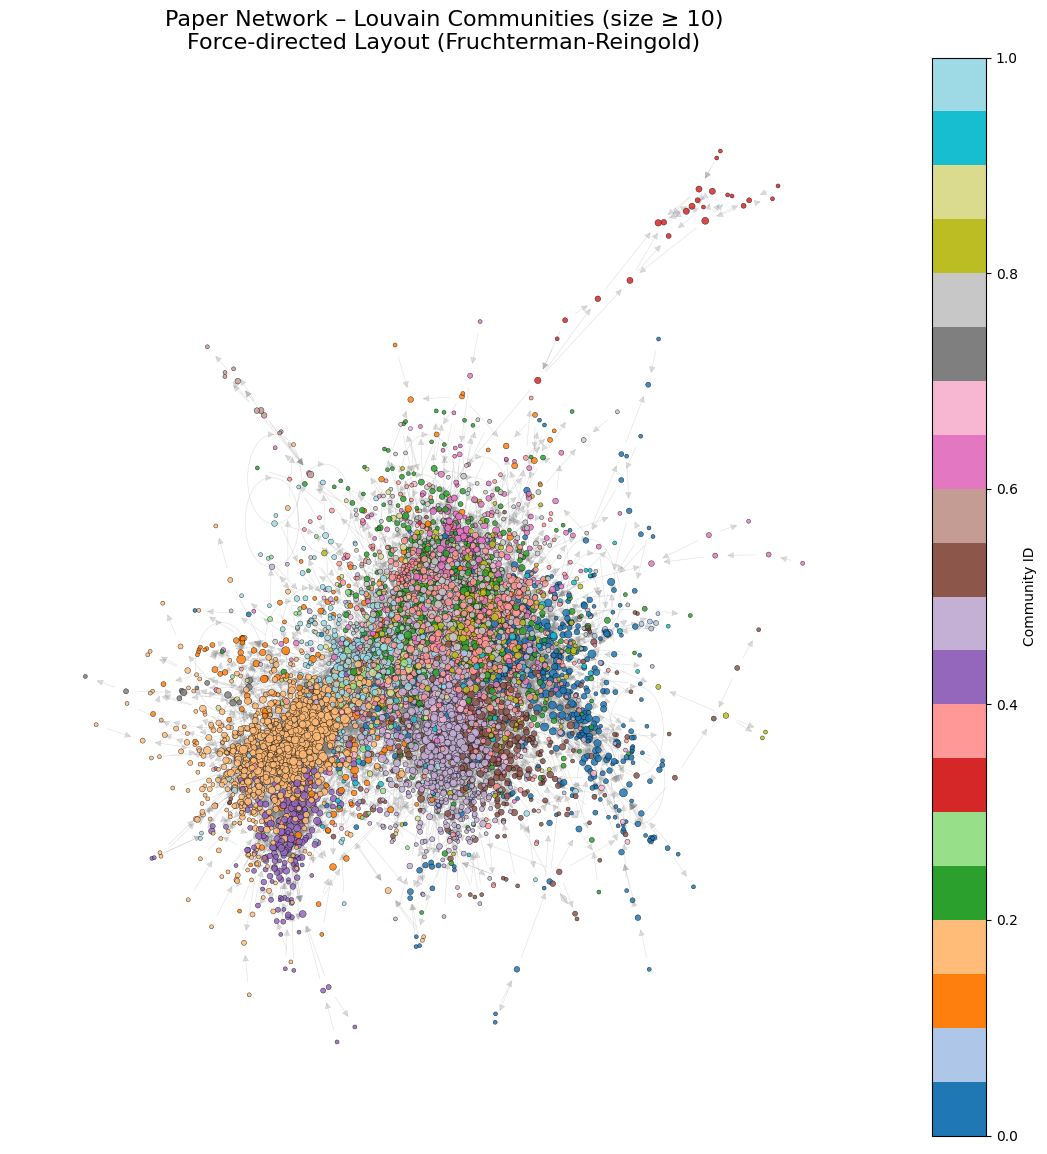

In [139]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ---------------------------------------------------------
# 1. Prepare Subgraph (only communities with >=10 nodes)
# ---------------------------------------------------------

print("Building subgraph of large communities...")

node2comm = {}  # map node -> community id
for cid, comm in enumerate(communities_big):
    for n in comm:
        node2comm[n] = cid

# All nodes belonging to any big community
nodes_big = list(node2comm.keys())

G_sub = G.subgraph(nodes_big).copy()
print(f"Subgraph has {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges.")

# ---------------------------------------------------------
# 2. Compute weighted degree and colors
# ---------------------------------------------------------

weighted_degree = dict(G_sub.degree(weight="weight"))
node_sizes = [np.log(d + 1) * 12 for d in weighted_degree.values()]

node_colors = [node2comm[n] for n in G_sub.nodes()]
max_comm_id = max(node2comm.values())
normalized_colors = [c / max_comm_id for c in node_colors]

# ---------------------------------------------------------
# 3. Fruchterman-Reingold layout (force-directed)
# ---------------------------------------------------------

print("Running Fruchterman-Reingold layout...")
pos = nx.fruchterman_reingold_layout(
    G_sub,
    k=0.15,        # controls spacing between clusters
    iterations=150
)

# ---------------------------------------------------------
# 4. Plot the network of communities >=10
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 14))

nodes = nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=node_sizes,
    node_color=normalized_colors,
    cmap=cm.get_cmap("tab20"),
    alpha=0.85,
    linewidths=0.3,
    edgecolors="black",
    ax=ax
)

nx.draw_networkx_edges(
    G_sub, pos,
    alpha=0.25,
    width=0.4,
    edge_color="gray",
    ax=ax
)

ax.set_title(
    "Paper Network – Louvain Communities (size ≥ 10)\n"
    "Force-directed Layout (Fruchterman-Reingold)",
    fontsize=16
)
ax.set_axis_off()

# colorbar
sm = cm.ScalarMappable(cmap=cm.get_cmap("tab20"))
sm.set_array(normalized_colors)
fig.colorbar(sm, ax=ax, label="Community ID")

plt.show()


Preparing community–node mapping...
Computing spring layout...


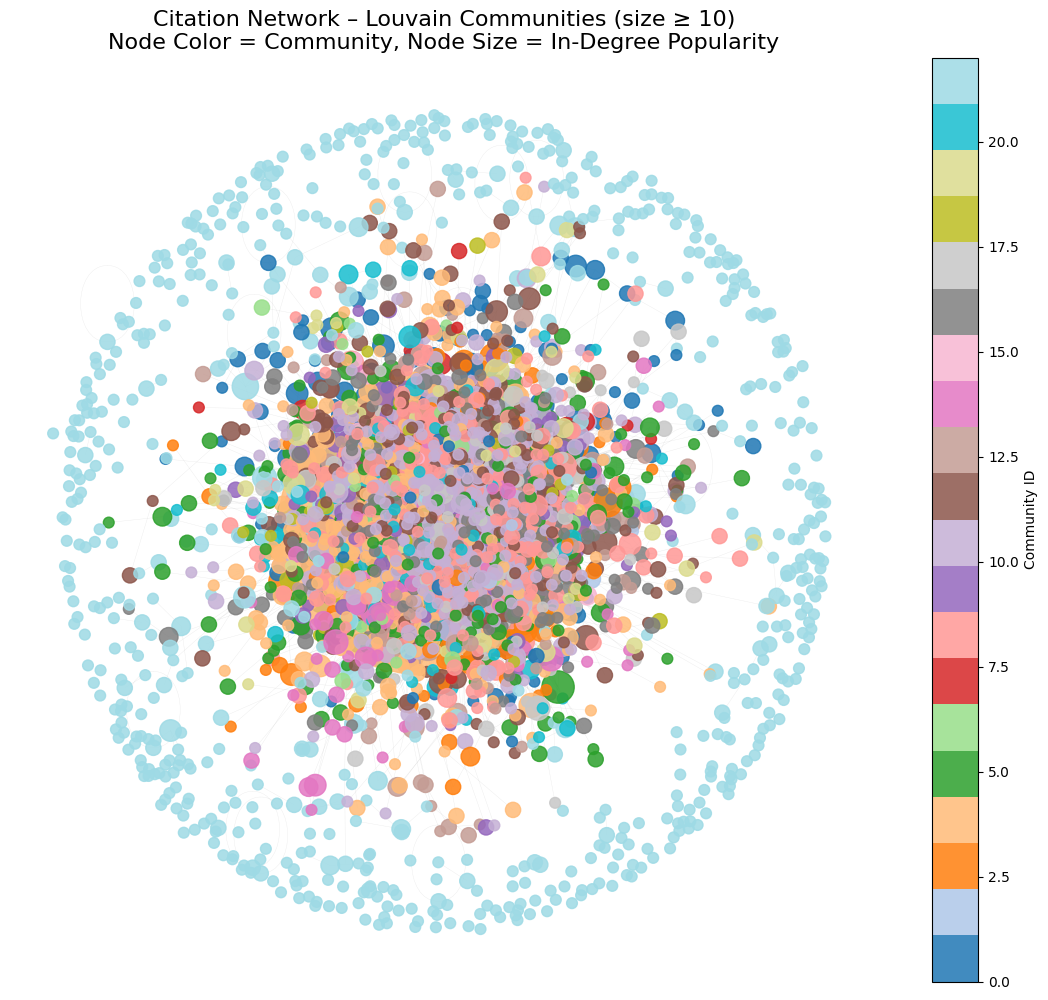

In [120]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ------------------------------------------
# 1. Use your big communities
# ------------------------------------------
print("Preparing community–node mapping...")

node2comm = {}
for cid, comm in enumerate(communities_big):
    for n in comm:
        node2comm[n] = cid

# Color for nodes without a community >=10
default_comm_id = len(communities_big)

# ------------------------------------------
# 2. Build color vector
# ------------------------------------------
node_colors = [
    node2comm.get(n, default_comm_id)
    for n in G_und.nodes()
]

# ------------------------------------------
# 3. Node sizes = in-degree popularity
# ------------------------------------------
node_sizes = np.array([G.in_degree(n) for n in G_und.nodes()])
node_sizes = 60 * (node_sizes + 1)  # nicer scaling

# ------------------------------------------
# 4. Compute spring layout (fast)
# ------------------------------------------
print("Computing spring layout...")
pos = nx.spring_layout(
    G_und,
    k=0.25,       # repulsion strength
    iterations=50,
    seed=42
)

# ------------------------------------------
# 5. Plot
# ------------------------------------------
plt.figure(figsize=(14, 12))

scatter = nx.draw_networkx_nodes(
    G_und,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap="tab20",
    alpha=0.85
)

nx.draw_networkx_edges(
    G_und,
    pos,
    width=0.3,
    alpha=0.15,
    edge_color="gray"
)

plt.title(
    "Citation Network – Louvain Communities (size ≥ 10)\n"
    "Node Color = Community, Node Size = In-Degree Popularity",
    fontsize=16
)

cbar = plt.colorbar(scatter)
cbar.set_label("Community ID")

plt.axis("off")
plt.show()


### Degree Distribution

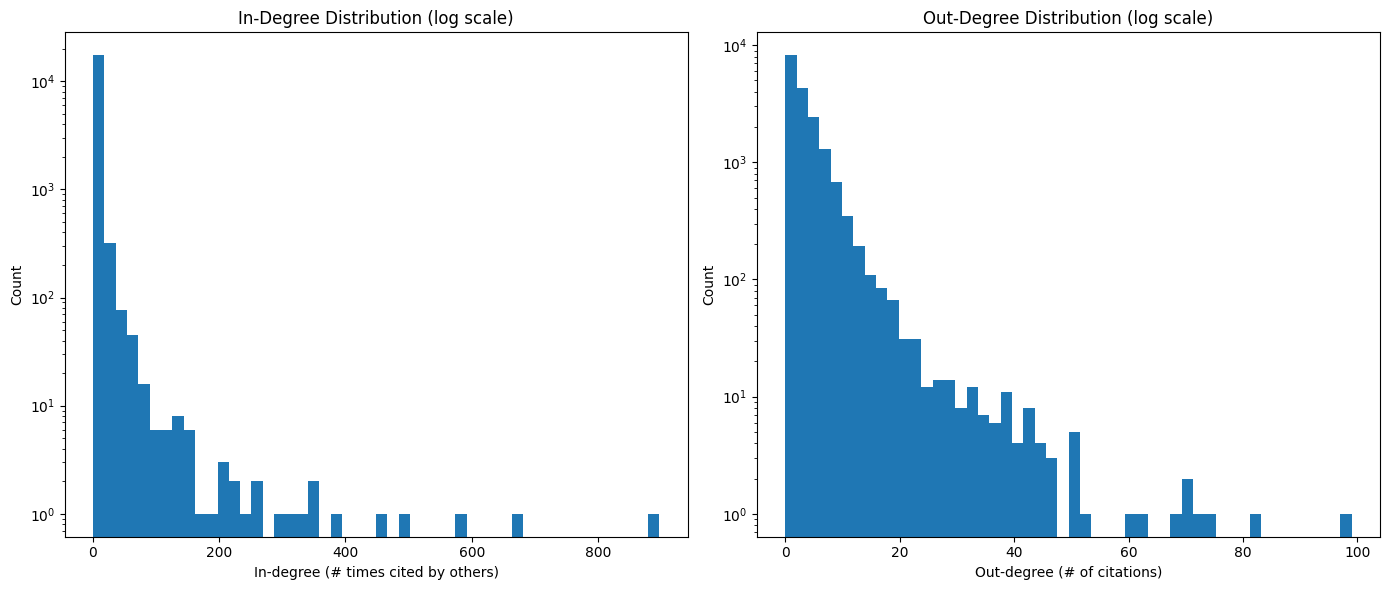

In [12]:
import matplotlib.pyplot as plt

in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("In-Degree Distribution (log scale)")
plt.xlabel("In-degree (# times cited by others)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Out-Degree Distribution (log scale)")
plt.xlabel("Out-degree (# of citations)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()
